In [14]:
from PIL import Image
import os, sys



jersey_path = "/Users/feliphlvo/Documents/Minerva/2022 Fall/CS156/PCA Image Reconstruction/Jerseys/"
jersey_dirs = os.listdir(jersey_path)

shirt_path = "/Users/feliphlvo/Documents/Minerva/2022 Fall/CS156/PCA Image Reconstruction/Shirts/"
shirt_dirs = os.listdir(shirt_path)

def resize(dirs, path, destination):
    for item in dirs:
        if os.path.isfile(path+item) and item != '.DS_Store':
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            if im.size[0] < 160 or im.size[1] < 160:
                continue
            imResize = im.resize((70,70), Image.ANTIALIAS)
            imResize.save(destination + item + ' resized.jpg', 'JPEG', quality=90)

resize(jersey_dirs, jersey_path, "/Users/feliphlvo/Documents/Minerva/2022 Fall/CS156/PCA Image Reconstruction/Resized_Jerseys/")
resize(shirt_dirs, shirt_path, "/Users/feliphlvo/Documents/Minerva/2022 Fall/CS156/PCA Image Reconstruction/Resized_Shirts/")

In [23]:

from collections import defaultdict
from glob import glob
from random import shuffle, seed
import numpy as np
import pylab as pl
import re
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
#if we do nothing, there are 256 * 256 * 256 = 16M possible RGB colors
# we don't want that many colors, so we'll use this many buckets for each of R, G, and B
NUM_BUCKETS = 3 # this means there will be 3 * 3 * 3 = 27 possible colors

bucket_size = 256 / NUM_BUCKETS

# these are the possible values for r, g, and b
quanta = [bucket_size * i for i in range(NUM_BUCKETS)]
colors = [(r,g,b)
           for r in quanta
           for g in quanta
           for b in quanta]

def quantize(rgb):
    """map a tuple (r,g,b) each between 0 and 255
    to our discrete color buckets"""

    r,g,b = rgb
    r = max([q for q in quanta if q <= r])
    g = max([q for q in quanta if q <= g])
    b = max([q for q in quanta if q <= b])
    return (r,g,b)

jerseys = glob('Resized_Jerseys/*')
shirts = glob('Resized_Shirts/*')

def color_dist(image_file):
    """given an image file, return its vector of colors
    (using the quantized colors defined previously)"""
    img = Image.open(image_file)
    num_pixels = img.size[0] * img.size[1]
    color_counts = defaultdict(int)
    for (c,rgb) in img.getcolors(num_pixels):
        try:
            color_counts[quantize(rgb)] += c
        except:
            print((c,rgb))

    # simplest possible is to return 1 if the image contains a color, 0 if it doesn't
    result = [(1 if color_counts[c] > 0 else 0) for c in colors]

    # another possibility would be to return the fraction of pixels that are that color
    # result = [1.0 * color_counts[c] / num_pixels for c in colors]
    return np.array(result)

def img_to_array(filename):
    """takes a filename and turns it into a numpy array of RGB pixels"""
    img = Image.open(filename)
    img = list(img.getdata())
    img = np.array(img)
    return img.flatten()

# now map each file into a tuple (features,label,filename)
# filename is just to make it easier to inspect the results later
data = ([(img_to_array(j),0,j) for j in jerseys[:10]] +
        [(img_to_array(s),1,s) for s in shirts[:10]])



In [24]:
seed(0)
shuffle(data)

# pull out the features and the labels
X = np.array([cd for (cd,_y,f) in data])
y = np.array([_y for (cd,_y,f) in data])

# and split it into a training set and a test set
train_split = int(len(data) * 4.0 / 5.0)

X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]


In [25]:
len(y)

20

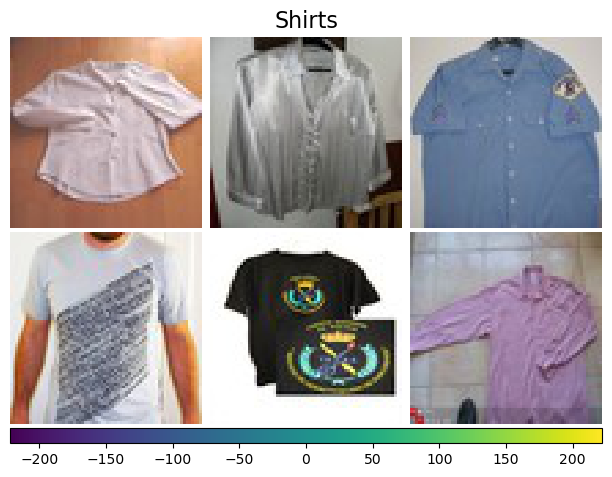

In [26]:
n_row, n_col = 2, 3
n_components = 10
image_shape = (70, 70, 3)
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")
    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()


plot_gallery("Shirts", X[:6])

In [27]:
from sklearn import decomposition
pca_estimator = decomposition.PCA(
    n_components=10, svd_solver="randomized")
X2 = pca_estimator.fit_transform(X)


In [28]:
X

array([[ 86,  71,  66, ..., 168, 107,  78],
       [159, 161, 160, ...,  60,  43,  13],
       [188, 186, 173, ...,  99,  93, 103],
       ...,
       [131, 125, 127, ...,  12,  68,  93],
       [ 13,   8,  12, ...,  53,  69, 105],
       [130, 118, 138, ...,  69,  47,  36]])

In [34]:
def image_from_component_values(component):
    """takes one of the principal components and turns it into an image"""
    hi = max(component)
    lo = min(component)
    n = int(len(component) / 3)
    divisor = hi - lo
    if divisor == 0:
        divisor = 1
    def rescale(x):
        return int(255 * (x - lo) / divisor)
    d = [(rescale(component[3 * i]),
          rescale(component[3 * i + 1]),
          rescale(component[3 * i + 2])) for i in range(n)]
    im = Image.new('RGB',(70, 70))
    im.putdata(d)
    #display(im)
    im = list(im.getdata())
    im = np.array(im)
    return im.flatten()
component = pca_estimator.components_[0]
print(component)
imtest = image_from_component_values(component)

[-0.01324392 -0.01473052 -0.01218162 ... -0.01513736 -0.01564973
 -0.01388887]


In [35]:
eigenshirts = [image_from_component_values(i) for i in pca_estimator.components_]


In [36]:
def construct(eigenvalues):
    components = pca_estimator.components_
    #print(len(eigenvalues), len(components))
    
    N = len(components[0])  
    #print(int(sum([w * c[2] for (w,c) in eigenzip])))
    r = []
    for i in range(N):
        eigenzip = zip(eigenvalues,components)
        r.append(int(sum([w * c[i] for (w,c) in eigenzip])))
#     r = [int(sum([w * c[i] for (w,c) in eigenzip]))
#                      for i in range(N)]

    img = image_from_component_values(r)
    return img
    
def reconstruct(dress_number):
    eigenvalues = X2[dress_number]
    img = construct(eigenvalues)
    return img

In [37]:
reconstructed_images = [reconstruct(i) for i in range(6)]

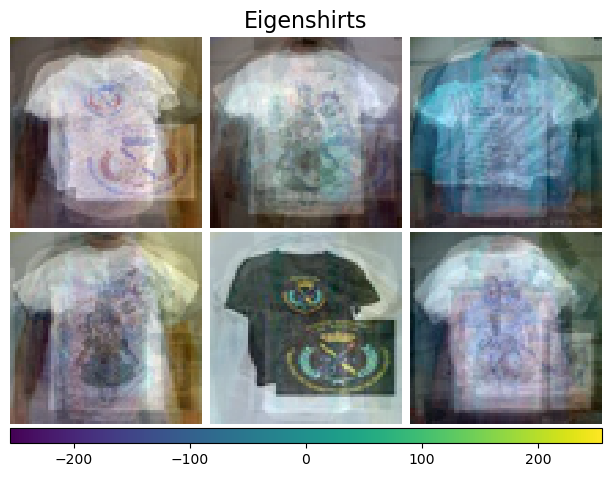

In [43]:
plot_gallery(
    "Eigenshirts", reconstructed_images
)